In [22]:
import fit
import metapso
import swarm

In [3]:
import json

In [4]:
with open("./metaswarm_output.json", "r") as f:
    metapso_results = json.load(f)

In [19]:
best_key = sorted(list(metapso_results["global_bests"].keys()))[-1]
best_params = dict(list(zip(metapso.meta_params, metapso_results["global_bests"][best_key])))
best_params["add_particle"] = 0.0
best_params

{'w': 0.4019163897703223,
 'C': 0.6384140653911362,
 'S': 0.390190780411753,
 'swapping': 0.5452719285035242,
 'velocities': 0.26976532199242387,
 'decrease_velocity': 0.060010677570263286,
 'replace_particle': 0.8960323925298055,
 'add_particle': 0.0}

In [21]:
stock_params = {
    "w": 0.5,
    "C": 0.4,
    "S": 0.2,
    "swapping": 0.0,
    "velocities": 0.0,
    "decrease_velocity": 0.0,
    "add_particle": 0.0,
    "replace_particle": 0.0,
}

In [31]:
task_names = ["rastrigin", "ackley", "sphere"]
n_iters = 10
size = 20
dims_list = [2, 5, 10, 25, 50]
epochs = 100

data = {}
for params, pname in [(best_params, "best"), (stock_params, "stock")]:
    data[pname] = {}
    for itask, task_name in enumerate(task_names):
        data[pname][task_name] = {}
        for dims in dims_list:
            task = fit.string_to_func[task_name]
            task_bounds = fit.bounds[task_name]
            task_best_loc = fit.actual_minimum(task_name, dims)
            task_best_val = task(task_best_loc)

            swarm_params = {
                "size": size,
                "dims": dims,
                "fitness": task_name,
                "bounds": task_bounds,
            }
            swarm_params.update(params)

            iter_errors = []
            for iter_ in range(n_iters):
                result = swarm.Swarm(**swarm_params).Run(epochs)
                g_best_key = sorted(list(result["global_bests"].keys()))[-1]
                g_best_val = task(result["global_bests"][g_best_key])
                mse = (task_best_val - g_best_val)**2
                iter_errors.append(mse)
                
            data[pname][task_name][dims] = iter_errors

In [32]:
data

{'best': {'rastrigin': {2: [8.17912380472449e-18,
    1.606830651626934e-22,
    5.25267766906842e-25,
    0.9899435277656033,
    1.4944788095859506e-22,
    3.853588276580706e-19,
    1.5652278476450671e-13,
    8.18530872179753e-19,
    1.4694739152088618e-16,
    1.3781974336504513e-19],
   5: [35.6439782011589,
    48.51228075820362,
    3.9598597360399004,
    17.667572814386045,
    3.960044652476979,
    35.65008041469382,
    63.35677579763376,
    194.03003461576893,
    8.967525685481068,
    8.909923509760095],
   10: [226.51917189015674,
    227.6247691286435,
    85.63871253183126,
    194.7090609366693,
    492.87372670810447,
    272.89831228071665,
    101.15792441866722,
    619.74976842062,
    17.484728590667725,
    194.8213054622904],
   25: [3598.2620349980716,
    1331.8751999256137,
    3566.2585880012293,
    7884.348731585318,
    6199.115072701593,
    6339.181219862702,
    6776.6084236517245,
    1565.7086020345407,
    2088.0917758880137,
    5576.3124848

In [33]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [46]:
def get_bar_offsets(n, w):
    if n % 2 == 0:
        l1 = [i*w/2 for i in range(1, n, 2)]
        l = sorted(l1 + [-1*i for i in l1])
        return l
    else:
        l1 = [i*w for i in range(0, (n-1)//2+1)]
        l = sorted(l1 + [-1*i for i in l1[1:]])
        return l

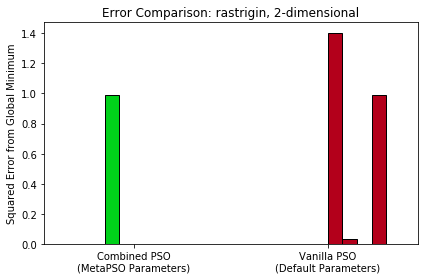

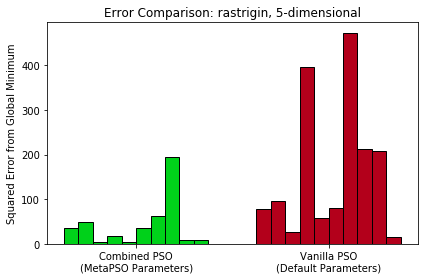

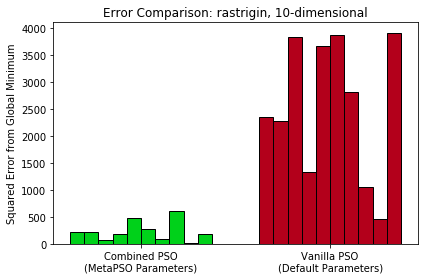

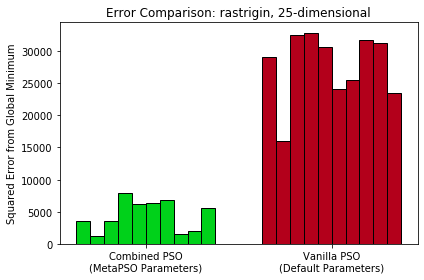

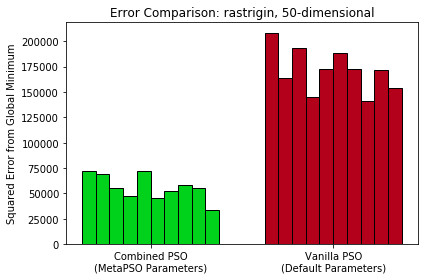

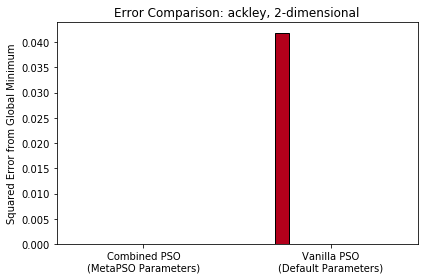

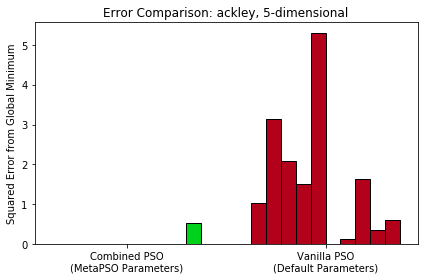

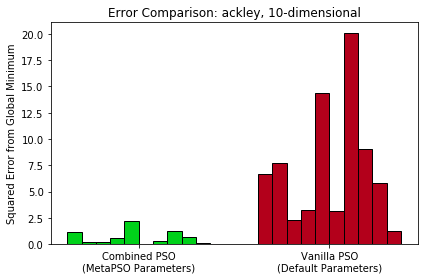

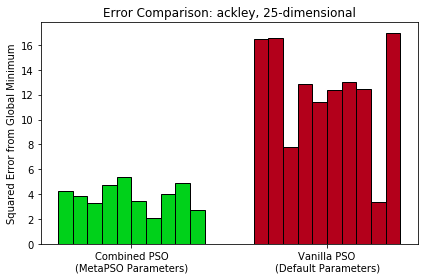

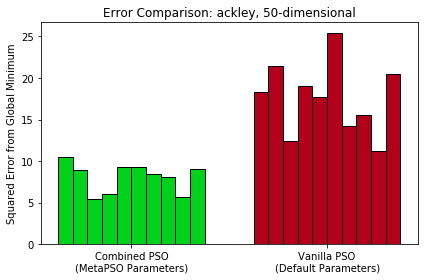

In [106]:
task_name = "rastrigin"
dims = 10
param_names = ["best", "stock"]
labels = {
    "best": "Combined PSO\n(MetaPSO Parameters)",
    "stock": "Vanilla PSO\n(Default Parameters)"
}


for task_name in ["rastrigin", "ackley"]:
    for dims in [2, 5, 10, 25, 50]:
        rearranged_data = list(zip(*[data[p][task_name][dims] for p in param_names]))
        rearranged_data = list(map(list, rearranged_data))

        x = np.arange(len(labels))  # the label locations
        width = 0.075  # the width of the bars

        fig, ax = plt.subplots()
        rects = [
            ax.bar(
                x + off,
                plot_data,
                width,
                edgecolor="black"
            )
            for plot_data, off
            in zip(
                rearranged_data,
                get_bar_offsets(len(rearranged_data), width)
            )
        ]
        
        # change colors
        for i in range(0, len(rects)):
            for j, facecolor in enumerate([(0, 0.819, 0.101, 1.0), (0.701, 0, 0.105, 1.0)]):
                rects[i][j].set_facecolor(facecolor)

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel("Squared Error from Global Minimum")
        ax.set_title(f"Error Comparison: {task_name}, {dims}-dimensional")
        ax.set_xticks(x)
        ax.set_xticklabels([labels[p] for p in param_names])
        fig.tight_layout()
        plt.savefig(f"./params_comparison_{task_name}_{dims}d.png")
        plt.show()